In [ ]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.v2 as T
from torchvision.datasets import CocoDetection
from torch.utils.data import Dataset, DataLoader

import io
import re
import os
import cv2
import base64
import random
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

!pip install hf_xet
from transformers import DetrImageProcessor, DetrForObjectDetection
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"running on {device}")

In [ ]:
# file paths
train_folder = Path(r"/kaggle/input/kidney-stone-images/train")
test_folder = Path(r"/kaggle/input/kidney-stone-images/test")
valid_folder = Path(r"/kaggle/input/kidney-stone-images/valid")

In [39]:
train_images = os.listdir(train_folder / "images")
train_labels = os.listdir(train_folder / "labels")

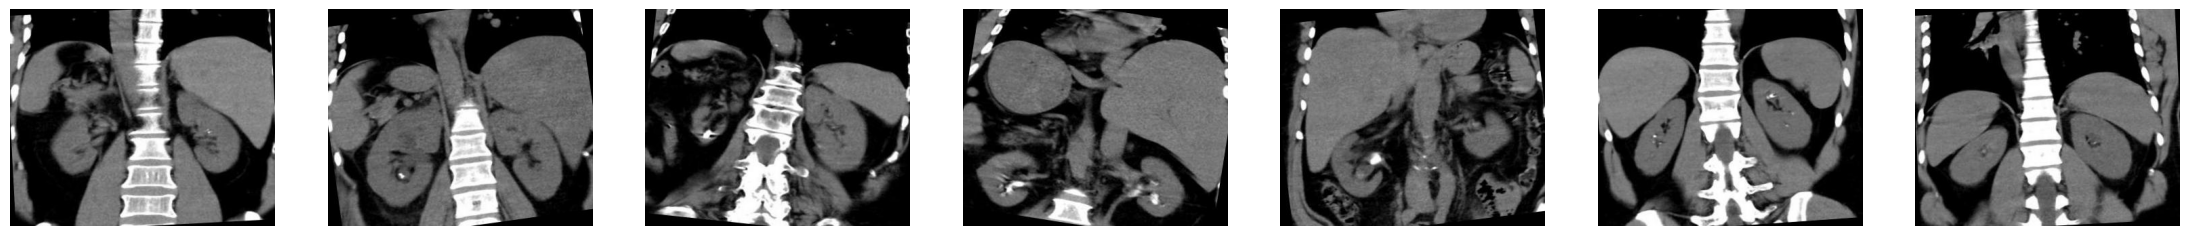

In [4]:
num_plots = 7
samples = torch.randperm(len(train_images))[:num_plots]

fig, axs = plt.subplots(nrows=1, ncols=num_plots, sharex=True, sharey=True, figsize=(4*num_plots,5))
for i in range(len(samples)):
    img_path = train_folder / "images" / train_images[samples[i]]
    img = Image.open(img_path)
    axs[i].imshow(img)
    axs[i].axis('off')

plt.show()

## kidney stone dataset

In [ ]:
# %%writefile data.py
"""
Class to handle datsets
"""

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.v2 as T
from torch.utils.data import Dataset, DataLoader


import re
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path

from transformers import DetrImageProcessor


class KidneyStoneDataset(Dataset):
    """
        Dataset Processor for Kidney stone dataset
    """
    def __init__(self, imgs_path, labels_path, transform, processor):
        super(KidneyStoneDataset, self).__init__()
        self.imgs_path = imgs_path
        self.labels_path = labels_path
        self.transform = transform
        self.processor = processor
        self.images, self.annotations_df = self.yolo2coco(imgs_path, labels_path)

        ### deepseek!!
        valid_images = []
        for img in self.images:
            if img in self.annotations_df['images'].values:
                valid_images.append(img)
                self.images = valid_images

    def yolo2coco(self, images_path, labels_path):
        annotations = {
        "images" : [],
        "class_id" : [],
        "x_center_norm" : [],
        "y_center_norm" : [],
        "width_norm" : [],
        "height_norm" : [],
        "width_act" : [],
        "height_act" : []
        }

        images = os.listdir(images_path)
    
        for image in images:
            
            # open label folder
            label_name = image[:-3] + "txt"
            label_path = labels_path / label_name
            img_path = images_path / image
    
            # Add this check
            if not os.path.exists(label_path):
                print(f"Label file missing for {image}, skipping")
                continue
            
            with open(label_path, 'r') as f:
                labels = f.readlines()

            width, height = Image.open(img_path).size # width, height

            if len(labels) == 1:
                annotations["images"].append(image)

                labels = labels[0]
                labels = re.sub(r"\n", "", labels)
                labels = re.sub(r",", "", labels)
                labels = labels.strip()
                id, x_cen, y_cen, w, h = [float(val) for val in labels.split(" ")]
            
                annotations["class_id"].append(id)
                annotations["x_center_norm"].append(x_cen)
                annotations["y_center_norm"].append(y_cen)
                annotations["width_norm"].append(w)
                annotations["height_norm"].append(h)
                annotations["width_act"].append(width)
                annotations["height_act"].append(height)
                
            elif len(labels) > 1:
                for label in labels:
                    label = re.sub(r"\n", " ", label)
                    label = re.sub(r",", " ", label)
                    label = label.strip()
                    id_, x_cen, y_cen, w, h = [float(val) for val in label.split(" ")]
                    annotations["images"].append(image)
                    annotations["class_id"].append(id_)
                    annotations["x_center_norm"].append(x_cen)
                    annotations["y_center_norm"].append(y_cen)
                    annotations["width_norm"].append(w)
                    annotations["height_norm"].append(h)
                    annotations["width_act"].append(width)
                    annotations["height_act"].append(height)
                
            else:
                # remove image from list of image
                img_idx = images.index(image)
                images = images[:img_idx] + images[img_idx:]

                print(f"image {image} has no labels, it has been removed from the dataset")

        annot_df = pd.DataFrame(annotations)


        # denormalize yolo format
        annot_df["x_center_abs"] = annot_df["x_center_norm"] * annot_df['width_act']
        annot_df["y_center_abs"] = annot_df["y_center_norm"] * annot_df["height_act"]
        annot_df["width_abs"] = annot_df["width_norm"] * annot_df['width_act']
        annot_df["height_abs"] = annot_df["height_norm"] * annot_df["height_act"]

        # convert to coco
        annot_df["x_min"] = annot_df["x_center_abs"] - (annot_df["width_abs"] / 2)
        annot_df["y_min"] = annot_df["y_center_abs"] - (annot_df["height_abs"] / 2)

        annot_df["class_id"] = annot_df["class_id"].astype('int')
        annot_df["x_min"] = annot_df["x_min"].apply(lambda x : round(x,1))
        annot_df["y_min"] = annot_df["y_min"].apply(lambda x : round(x,1))
        annot_df["width_abs"] = annot_df["width_abs"].apply(lambda x : round(x,1))
        annot_df["height_abs"] = annot_df["height_abs"].apply(lambda x : round(x,1))

        annot_df = annot_df[['images', 'class_id', 'x_min', 'y_min', 'width_abs', 'height_abs']]

        return images, annot_df 


    def __len__(self):
        return len(self.images)

  
    def __getitem__(self, idx):
        image_name = self.images[idx]
        img_path = self.imgs_path / image_name
        img = Image.open(img_path).convert("RGB")  # Ensure RGB format

        if self.transform:
            img = self.transform(img)
    
        # Get annotations for this image
        image_annots = self.annotations_df[self.annotations_df['images'] == image_name]
        
        # Convert to COCO format
        annotations = []
        for _, row in image_annots.iterrows():
            annotation = {
                "bbox": [
                    row['x_min'],
                    row['y_min'],
                    row['width_abs'],
                    row['height_abs']
                ],
                "category_id": row['class_id'],
                "area": row['width_abs'] * row['height_abs'],
                "iscrowd": 0
            }
            annotations.append(annotation)
        
        # Create target in COCO format
        target = {
            "image_id": torch.tensor([idx]),  # Using index as image_id
            "annotations": annotations
        }
        
        # Process with DETR processor
        encoding = self.processor(
            images=img, 
            annotations=target, 
            return_tensors="pt"
        )
        
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension
    
        return pixel_values, target


In [ ]:
# image processor ("facebook/detr-resnet-50") on huggingface
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

In [ ]:
# transforms for the inputs
transform = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float)
])

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch


BATCH_SIZE = 16
train_dataset = KidneyStoneDataset(train_folder / "images", train_folder / "labels", transform, processor=processor)
val_dataset = KidneyStoneDataset(valid_folder / "images", valid_folder / "labels", transform, processor=processor)

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=3)
val_dataloader = DataLoader(val_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=3)

print(f"train_dataloader: {len(train_dataloader)}")
print(f"val_dataloader: {len(val_dataloader)}")

## plot sample of processed image

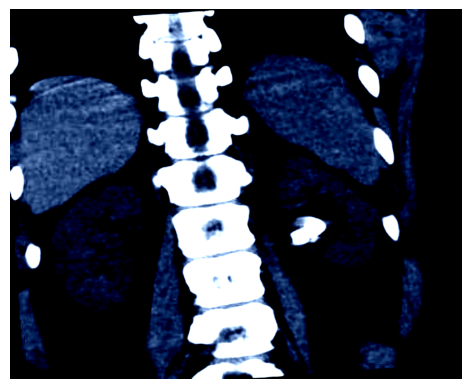

In [9]:
sample = 8
batch = next(iter(train_dataloader))
# pixel values shows the augmentation image that makes the regions of interest pop
plt.imshow(batch['pixel_values'][sample].permute(1,2,0))
plt.axis('off')
plt.show()

## Training 

In [13]:
# %%writefile 'engine.py'

"""
    The Model to be trained
"""

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.v2 as T
from torch.utils.data import Dataset, DataLoader

import numpy as np

import pytorch_lightning as pl
from transformers import DetrImageProcessor, DetrForObjectDetection

class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         # we specify the "no_timm" variant here to not rely on the timm library
         # for the convolutional backbone
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm",
                                                             num_labels=1,
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask,output_attentions=True):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, output_attentions=output_attentions)
       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        
        # Get actual batch size (number of samples in this batch)
        batch_size = batch["pixel_values"].shape[0]  
        
        # Log with explicit batch size
        self.log("training_loss", loss, batch_size=batch_size)
        for k, v in loss_dict.items():
            self.log(f"train_{k}", v.item(), batch_size=batch_size)
        
        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        
        batch_size = batch["pixel_values"].shape[0]
        
        self.log("validation_loss", loss, batch_size=batch_size)
        for k, v in loss_dict.items():
            self.log(f"validation_{k}", v.item(), batch_size=batch_size)
        
        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]

        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [17]:
# for some hugging face functionality !pip install hf_xet
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4).to(device)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## train the model

In [16]:
from pytorch_lightning import Trainer

trainer = Trainer(max_steps=300, gradient_clip_val=0.1)
trainer.fit(model)

## push trained model to huggingface hub

In [17]:
# login to huggingface

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("DATICAN")

from huggingface_hub import login
login(token=secret_value_0)

In [ ]:
# save trained model to huggingface
model.model.push_to_hub("bamswastaken/datican-detr-v2")

## Utility functions

In [18]:
def get_attention_map(postprocessed_outputs, outputs):
    """
    Gets attention map from bounding box with highest confidence.
    Args:
        postprocessed_outputs: [scores, labels, boxes]
        outputs: model output
    Returns:
        2d attention map
    """
    scores = postprocessed_outputs[0]['scores']
    if len(scores) > 0:
        highest_conf_idx = scores.argmax()
        highest_conf_query_idx = highest_conf_idx.item()  # This is the query index for the highest confidence box
    highest_conf_query_idx

    layer_idx = -1 # last layer, usually more refined
    head_idx = 6

    cross_attentions = outputs.cross_attentions
    attn_weights = cross_attentions[layer_idx][0]
    # attention_map = attn_weights[head_idx, highest_conf_query_idx] # attention map for bbox with largest confidence
    attention_map = attn_weights.mean(dim=0)[highest_conf_query_idx] # attention map for bbox with largest confidence averaged over all heads


     # Validate attention map size
    num_elements = attention_map.numel()
    if num_elements == 775: 
        attention_map_2d = attention_map.reshape(25, int(775 / 25))
    else:
        # Fallback for unexpected sizes
        side_length = int(num_elements**0.5)
        print(f"error_zone: {attention_map.shape}")
        attention_map_2d = attention_map.reshape(25, -1) # infer dim


    # reshape attention map
    # attention_map_2d = attention_map.reshape(25, int(775 / 25)) # this causes an error

    return attention_map_2d

def attention_to_overlay(original_image, attention_map, plot=False):
    """
    Overlays attention heatmap on the original image.
    Args:
        original_image: PIL Image (RGB)
        attention_map: 2D torch tensor (H, W)
        plot: plot image
    Returns:
        PIL Image (RGB) with heatmap overlay in base64 format
    """
    # Convert original image to numpy array
    original = np.array(original_image)
    
    # Resize attention map to match original image dimensions
    attention_resized = F.interpolate(
        attention_map.unsqueeze(0).unsqueeze(0).float(),
        size=(original.shape[0], original.shape[1]),
        mode='bilinear',
        align_corners=False
    ).squeeze().cpu().numpy()
    
    # Normalize attention map to [0, 1]
    attention_normalized = (attention_resized - attention_resized.min()) / (attention_resized.max() - attention_resized.min())
    
    # Apply colormap (viridis) to attention map
    heatmap = plt.cm.viridis(attention_normalized)[..., :3]  # RGBA → RGB, range [0, 1]
    
    # Blend original image and heatmap (50% opacity)
    overlayed = 0.5 * original + 0.5 * heatmap * 255
    overlayed = np.clip(overlayed, 0, 255).astype(np.uint8)
    
    # converts numpy array to PIL Image
    
    if plot:
        plt.imshow(overlayed)
        plt.title("Cross Attention Map of Bounding box with the highest accuracy")
        plt.axis('off')
        plt.show()
    else:    
        attn_img_overlay = Image.fromarray(overlayed) 
    
        buffered = io.BytesIO()
        attn_img_overlay.save(buffered, format="PNG")
        atten_img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
        return atten_img_str 

def scale_bbox_to_img_size(preprocessed_img, image, boxes):
    """
    Scales bounding box predictions to actual image size
    Args:
        preprocessed_img: image passed through huggingface transforms
        image: PIL image
        boxes: bounding box predictions
    Returns:
        scaled bounding boxes
    """
    pp_width, pp_height = preprocessed_img.shape[-2:] # (1,3,800,977)
    image_height, image_width = image.size
    
    # bbox is in pp_image format, scale to actual image format
    width_scale = image_width / pp_width
    height_scale =  image_height / pp_height

    new_boxes = []
    for box in boxes:

        if torch.is_tensor(box):
            box = box.cpu().numpy()

        scaled_box = np.array(box, dtype=np.float32)

        scaled_box[0:3:2] = scaled_box[0:3:2] * width_scale # the width (x1, x2)
        scaled_box[1:4:2] = scaled_box[1:4:2] * height_scale # the height (y1, y2)
        new_boxes.append(scaled_box)
        
    return new_boxes

def image_with_bboxes(pil_img, scores, labels, scaled_boxes, plot=False):
    """
    Scales bounding box predictions to actual image size
    Args:
        pil_img: image 
        scores: detection confidences 
        scaled_boxes: scaled bounding box predictions
        plot: plot image
    Returns:
        PIL Image (RGB) with bounding boxes in base64 format
    """
    
    img_np = np.array(pil_img)
    img_cv = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)

    boxcolor = (50,200,50)
    textcolor = (255,255,255)

    for score, label, (xmin, ymin, xmax, ymax) in zip(scores, labels, scaled_boxes):
        cv2.rectangle(img_cv, (int(xmin), int(ymin)), (int(xmax), int(ymax)), boxcolor, 1)
        cv2.putText(img_cv, f'stone: {score:.2f}', (int(xmin), int(ymin)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, textcolor)

    if plot:
        plt.imshow(img_cv)
        plt.axis('off')
        plt.show
    else:
        bbox_on_image = Image.fromarray(img_cv)
        buffered = io.BytesIO()
        bbox_on_image.save(buffered, format="PNG")
        bbox_on_image_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
        return bbox_on_image_str

## run inference on trained model

In [19]:
hf_model = DetrForObjectDetection.from_pretrained("bamswastaken/datican-detr-v2",num_labels=1, ignore_mismatched_sizes=True)
hf_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

config.json:   0%|          | 0.00/3.38k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

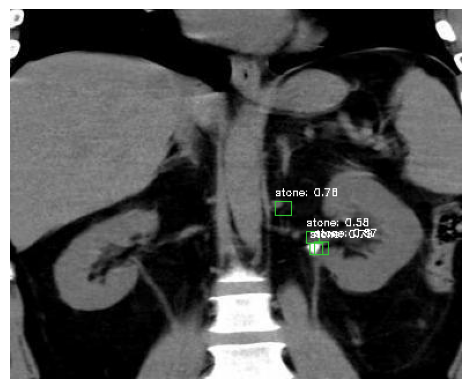

In [ ]:
sample = 100
image_path = os.listdir(valid_folder / "images")[sample]
image = Image.open(valid_folder / "images" / image_path)

# apply transforms
transform = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float)
])

img_trans = transform(image).unsqueeze(dim=0)
encoding = processor(images=img_trans, return_tensors="pt")

# input image with transforms applied
preprocessed_img = encoding['pixel_values'] # b,c,h,w

# get bboxes and confidences
with torch.no_grad():
    # forward pass to get class logits and bounding boxes
    outputs = hf_model(pixel_values=preprocessed_img, pixel_mask=None,output_attentions=True)
    # ['logits', 'pred_boxes', 'last_hidden_state', 'decoder_attentions', 'cross_attentions', 'encoder_last_hidden_state', 'encoder_attentions'])


postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(preprocessed_img.shape[2], preprocessed_img.shape[3])],
                                                                threshold=0.5)
bboxes = postprocessed_outputs[0]

# convert from tensors
bboxes = {k: v.numpy().tolist() for k,v in bboxes.items()} # if on gpu put .detach().cpu()

boxes = scale_bbox_to_img_size(preprocessed_img, image, bboxes['boxes'])
img_with_bboxes = image_with_bboxes(image, bboxes['scores'], bboxes['labels'], boxes, plot=True)

attn_map = get_attention_map(postprocessed_outputs, outputs)
atten_img = attention_to_overlay(image, attn_map, plot=False)


In [24]:
bboxes

{'scores': [0.5790722370147705,
  0.849091649055481,
  0.5053185820579529,
  0.7572062611579895,
  0.5407137870788574],
 'labels': [0, 0, 0, 0, 0],
 'boxes': [[395.2999267578125,
   634.9752807617188,
   442.2406311035156,
   668.3345336914062],
  [683.9970703125, 472.207275390625, 756.6589965820312, 543.7049560546875],
  [132.3870849609375,
   554.1322631835938,
   159.58607482910156,
   585.5792846679688],
  [719.1461181640625, 513.904541015625, 747.791748046875, 539.8642578125],
  [685.353515625, 464.73406982421875, 739.00146484375, 501.6497497558594]]}

In [25]:
bboxes['boxes'] = [box.tolist() for box in boxes]

In [26]:
bboxes

{'scores': [0.5790722370147705,
  0.849091649055481,
  0.5053185820579529,
  0.7572062611579895,
  0.5407137870788574],
 'labels': [0, 0, 0, 0, 0],
 'boxes': [[158.11997985839844,
   254.12010192871094,
   176.89625549316406,
   267.47064208984375],
  [273.5988464355469,
   188.97958374023438,
   302.6636047363281,
   217.59329223632812],
  [52.954833984375, 221.76634216308594, 63.83443069458008, 234.35159301757812],
  [287.658447265625, 205.66702270507812, 299.11669921875, 216.0562286376953],
  [274.14141845703125, 185.98876953125, 295.6005859375, 200.76260375976562]]}